# Q. #3

In [1]:
# Import all the functions used in part 1
from era_okid_tools import *

# Logistics
warnings.simplefilter("ignore", UserWarning)
sympy.init_printing()
figs_dir = (Path.cwd() / "figs")
figs_dir.mkdir(parents = True, exist_ok = True)
prob = 3

In [2]:
def okid_ic(Z: np.ndarray, U: np.ndarray,
            l_0: int,
            alpha: int, beta: int,
            n: int):
    """Observer Kalman Identification Algorithm (OKID) with nonzero initial conditions.

    :param np.ndarray Z: Observation vector array over duration
    :param np.ndarray U: Continual inputs
    :param int l_0: Order of OKID to execute (i.e., number of Markov parameters to generate via OKID)
    :param int alpha: Num. of rows of Markov parameters in Hankel matrix
    :param int beta: Num. of columns of Markov parameters in Hankel matrix
    :param int n: Number of proposed states to use for ERA
    :return: (Y) Markov parameters, (Y_og) Observer Gain Markov parameters
    :rtype: typing.Tuple[np.ndarray, np.ndarray]
    """
    r, l_u = U.shape
    m, l = Z.shape
    assert l == l_u
    V = np.concatenate([U, Z], 0)
    assert (max([alpha + beta, (n/m) + (n/r)]) <= l_0) and (l_0 <= (l - r)/(r + m)) # Boundary conditions

    # Form observer
    Y_2_Z = np.zeros([r + (r + m)*l_0, l])
    Y_2_Z[:r, :] = U
    for i in range(1, l_0 + 1):
        Y_2_Z[((i*r) + ((i - 1)*m)):(((i + 1)*r) + (i*m)), :] = np.concatenate([np.zeros([r + m, i]), V[:, 0:(-i)]], 1)
    Y_2_Z_ic = Y_2_Z[:, l_0:]
    # Find Observer Markov parameters via least-squares
    Y_obs = Z[:, l_0:] @ spla.pinv2(Y_2_Z_ic)
    Y_bar_1 = np.array(list(it.chain.from_iterable([Y_obs[:, i:(i + r)]
                                                    for i in range(r, r + (r + m)*l_0, r + m)]))).reshape([l_0, m, r])
    Y_bar_2 = -np.array(list(it.chain.from_iterable([Y_obs[:, i:(i + m)]
                                                     for i in range(2*r, r + (r + m)*l_0, r + m)]))).reshape([l_0, m, m])

    # Obtain Markov parameters from Observer Markov parameters
    Y = np.zeros([l_0 + 1, m, r])
    Y[0] = Y_obs[:, :r]
    for k in range(1, l_0 + 1):
        Y[k] = Y_bar_1[k - 1] - \
               np.array([Y_bar_2[i] @ Y[k - (i + 1)]
                         for i in range(k)]).sum(axis = 0)
    # Obtain Observer Gain Markov parameters from Observer Markov parameters
    Y_og = np.zeros([l_0, m, m])
    Y_og[0] = Y_bar_2[0]
    for k in range(1, l_0):
        Y_og[k] = Y_bar_2[k] - \
                  np.array([Y_bar_2[i] @ Y_og[k - (i + 1)]
                            for i in range(k - 1)]).sum(axis = 0)
    return Y, Y_og

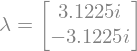

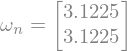

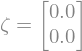

In [3]:
# Set seed for consistent results
rng = np.random.default_rng(seed = 100)

# Simulation dimensions
cases = 3 # Number of cases
n = 2 # Number of states
r = 1 # Number of inputs
m = 2 # Number of measurements
t_max = 50 # Total simulation time
dt = 0.1 # Simulation timestep duration
nt = int(t_max/dt) # Number of simulation timesteps

# Simulation time
train_cutoff = int(20/dt) + 1
t_sim = np.linspace(0, t_max, nt + 1)
t_train = t_sim[:train_cutoff]
t_test = t_sim
nt_train = train_cutoff
nt_test = nt

# Problem parameters
theta_0 = 0.5 # Angular velocity
k = 10 # Spring stiffness
mass = 1 # Point mass

# State space model
A_c = np.array([[0, 1], [theta_0**2 - k/mass, 0]])
B_c = np.array([[0], [1]])
C = np.eye(2)
D = np.array([[0], [1]])
A, B = c2d(A_c, B_c, dt)
eig_A = spla.eig(A_c)[0] # Eigenvalues of true system
etch(f"\lambda", eig_A)
etch(f"\omega_{{n}}", np.abs(eig_A))
etch(f"\zeta", -np.cos(np.angle(eig_A)))
# Note that damping is always positive even when it is displayed as negative.

# True simulation values
# X_0_sim = np.zeros([n, 1]) # Zero initial condition
X_0_sim = rng.uniform(-1, 1, [n, 1]) # Uniformly random initial condition
U_sim = np.zeros([cases, r, nt]) # True input vectors
U_sim[0] = rng.normal(0, 0.1, [r, nt]) # True input for case 1
U_sim[1] = spsg.square(2*np.pi*5*t_sim[:-1]) # True input for case 2
U_sim[2] = np.cos(2*np.pi*2*t_sim[:-1]) # True input for case 3
X_sim = np.zeros([cases, n, nt + 1]) # True state vectors
Z_sim = np.zeros([cases, m, nt]) # True observation vectors

# Separation into train and test data
U_train = U_sim[0, :r, :train_cutoff] # Train input vector
U_test = U_sim # Test input vectors
X_train = np.zeros([n, nt_train + 1]) # Train state vector
X_test = np.zeros([cases, n, nt_test + 1]) # Test state vectors
Z_train = np.zeros([m, nt_train]) # Train observation vector
Z_test = np.zeros([cases, m, nt_test]) # Test observation vectors
V_train = np.zeros([r + m, nt_train]) # Train observation input vectors
V_test = np.zeros([cases, r + m, nt_test]) # Test observation input vectors

In [4]:
# OKID logistics
order = 8 # Order of OKID algorithm, number of Markov parameters to identify after the zeroeth
alpha, beta = 4, 3 # Number of block rows and columns in Hankel matrices
n_era = 2 # Number of proposed states
X_0_okid = np.zeros([n_era, 1]) # Zero initial condition

print(f"Min. OKID Order: {max([alpha + beta, (n_era/m) + (n_era/r)]):n}")
print(f"Max. OKID Order: {(nt_train - r)/(r + m):n}")
print(f"Proposed OKID Order: {order:n}")

Min. OKID Order: 7
Max. OKID Order: 66.6667
Proposed OKID Order: 8


To fit the new purpose of OKID with initial condition,
we propose to use an OKID order
$l_0$ of 8, Hankel height $\alpha = 4$, Hankel width $\beta = 3$,
and assumed system order $n_{ERA} = 2$. All of these are in line
with what was discussed in the first problem, i.e., the boundary
conditions for the order size and the singular values as displayed below.

In [5]:
# OKID System Markov parameters
Y_okid = np.zeros([order + 1, m, r])
# OKID Observer Markov Gain parameters
Y_og_okid = np.zeros([order, m, m])
# OKID state vector, drawn from state space model derived from OKID/ERA
X_okid_train = np.zeros([n_era, nt_train + 1])
X_okid_test = np.zeros([cases, n_era, nt_test + 1])
X_okid_train_obs = np.zeros([n_era, nt_train + 1])
X_okid_test_obs = np.zeros([cases, n_era, nt_test + 1])
# OKID observations, drawn from state space model derived from OKID/ERA
Z_okid_train = np.zeros([n_era, nt_train])
Z_okid_test = np.zeros([cases, n_era, nt_test])
Z_okid_train_obs = np.zeros([n_era, nt_train])
Z_okid_test_obs = np.zeros([cases, n_era, nt_test])
# Singular values of the Hankel matrix constructed through OKID Markov parameters
S_okid = np.zeros([min(alpha*m, beta*r)])
eig_A_okid = np.zeros([n_era], dtype = complex)

# OKID/ERA state space model
A_okid = np.zeros([n_era, n_era])
B_okid = np.zeros([n_era, r])
C_okid = np.zeros([m, n_era])
D_okid = np.zeros([m, r])
G_okid = np.zeros([m, m])
# OKID/ERA state space model augmented with observer
A_okid_obs = np.zeros([n_era, n_era])
B_okid_obs = np.zeros([n_era, r + m])
C_okid_obs = np.zeros([m, n_era])
D_okid_obs = np.zeros([m, r + m])

Rank of H(0): 3
Rank of H(1): 3


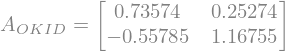

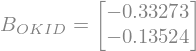

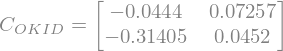

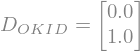

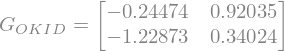

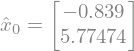

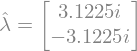

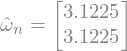

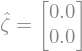

In [6]:
# Simulation
for i in range(cases):
    X_sim[i], Z_sim[i] = sim_ss(A, B, C, D, X_0 = X_0_sim, U = U_sim[i], nt = nt)
    if i == 0:
        # Split between train and test data for case 1
        X_train, Z_train = X_sim[i, :, :train_cutoff], Z_sim[i, :, :train_cutoff]
        # Identify System Markov parameters and Observer Gain Markov parameters
        Y_okid, Y_og_okid = okid_ic(Z_train, U_train,
                                    l_0 = order, alpha = alpha, beta = beta, n = n_era)
        # Identify state space model using System Markov parameters for ERA
        A_okid, B_okid, C_okid, D_okid, S_okid = \
            era(Y_okid, alpha = alpha, beta = beta, n = n_era)
        # Construct observability matrix
        O_p_okid = np.array([C_okid @ np.linalg.matrix_power(A_okid, i)
                             for i in range(order)])
        # Identify initial state
        CABu = np.concatenate([np.zeros([1, n_era, r]),
                               np.array([np.array([C_okid @ np.linalg.matrix_power(A_okid, i) @ B_okid * U_train[0, k - (i + 1)]
                                                   for i in range(k)]).sum(axis = 0)
                                         for k in range(1, order)])],
                              axis = 0)
        Du = np.array([D_okid * U_train[0, i]
                       for i in range(order)])
        X_0_id = spla.pinv2(O_p_okid.reshape([order*m, n_era])) @ \
                 (Z_train[:, :order].reshape([order*m, r]) - (CABu + Du).reshape([order*m, r]))
        # Find observer gain matrix
        G_okid = spla.pinv2(O_p_okid.reshape([order*m, n_era])) @ Y_og_okid.reshape([order*m, m])
        # Augment state space model with observer
        A_okid_obs = A_okid + G_okid @ C_okid
        B_okid_obs = np.concatenate([B_okid + G_okid @ D_okid, -G_okid], 1)
        C_okid_obs = C_okid
        D_okid_obs = np.concatenate([D_okid, np.zeros([m, m])], 1)
        V_train = np.concatenate([U_train, Z_train], 0)
        # Simulate OKID realization with "raw" state and OKID realization with estimated state
        X_okid_train, Z_okid_train = \
            sim_ss(A_okid, B_okid, C_okid, D_okid,
                   X_0 = X_0_id, U = U_train, nt = nt_train)
        X_okid_train_obs, Z_okid_train_obs = \
            sim_ss(A_okid_obs, B_okid_obs, C_okid_obs, D_okid_obs,
                   X_0 = X_0_id, U = V_train, nt = nt_train)
        # Display outputs
        etch(f"A_{{OKID}}", A_okid)
        etch(f"B_{{OKID}}", B_okid)
        etch(f"C_{{OKID}}", C_okid)
        etch(f"D_{{OKID}}", D_okid)
        etch(f"G_{{OKID}}", G_okid)
        etch(f"\hat{{x}}_0", X_0_id)
        # Calculate and display eigenvalues
        eig_A_okid = spla.eig(d2c(A_okid, B_okid, dt)[0])[0] # Eigenvalues of identified system
        etch(f"\hat{{\lambda}}", eig_A_okid)
        etch(f"\hat{{\omega}}_{{n}}", np.abs(eig_A_okid))
        etch(f"\hat{{\zeta}}", -np.cos(np.angle(eig_A_okid)))
    X_test[i], Z_test[i] = X_sim[i], Z_sim[i]
    X_okid_test[i], Z_okid_test[i] = \
        sim_ss(A_okid, B_okid, C_okid, D_okid,
               X_0 = X_0_id, U = U_test[i], nt = nt_test)
    V_test[i] = np.concatenate([U_test[i], Z_test[i]], 0)
    X_okid_test_obs[i], Z_okid_test_obs[i] = \
        sim_ss(A_okid_obs, B_okid_obs, C_okid_obs, D_okid_obs,
               X_0 = X_0_id, U = V_test[i], nt = nt_test)

The eigenvalues of the system, as well
as the corresponding natural frequencies and damping ratios,
are accurately identified via the new
OKID formulation for the system with nonzero initial condition.
This makes sense, since changing the initial condition of the system does
not change the underlying dynamics of the system,
allowing OKID to identify the modes well.

In [7]:
RMS_train = np.sqrt(np.mean((Z_okid_train - Z_train)**2, axis = 1))
print(f"RMS Error of sim. for system found via OKID for train data: {RMS_train}")
RMS_test = np.zeros([cases, m])
for i in range(cases):
    RMS_test[i] = np.sqrt(np.mean((Z_okid_test[i] - Z_test[i])**2, axis = 1))
    print(f"RMS Error of sim. for system found via OKID for test data, case {i}: {RMS_test[i]}")

RMS Error of sim. for system found via OKID for train data: [0.1685842  0.52691283]
RMS Error of sim. for system found via OKID for test data, case 0: [0.16824344 0.52797367]
RMS Error of sim. for system found via OKID for test data, case 1: [0.16824344 0.52797367]
RMS Error of sim. for system found via OKID for test data, case 2: [0.16824344 0.52797367]


In [8]:
# Eigenvalue plots
fig, ax = plt.subplots(constrained_layout = True) # type:figure.Figure
fig.suptitle(f"[{prob}] Eigenvalues", fontweight = "bold")

ax.plot(np.real(eig_A), np.imag(eig_A),
         "o", mfc = "None")
ax.plot(np.real(eig_A_okid), np.imag(eig_A_okid),
         "s", mfc = "None")

fig.legend(labels = ("True", "OKID"),
           bbox_to_anchor = (1, 0.5), loc = 6)
fig.savefig(figs_dir / f"midterm_{prob}_eigval.pdf",
            bbox_inches = "tight")

# Singular Value plots
fig, ax = plt.subplots(constrained_layout = True) # type:figure.Figure
fig.suptitle(f"[{prob}] Singular Values", fontweight = "bold")

ax.plot(np.linspace(1, len(S_okid), len(S_okid)), S_okid,
         "o", mfc = "None")
plt.setp(ax, xlabel = f"Singular Value", ylabel = f"Value",
         xticks = np.arange(1, len(S_okid) + 1))

fig.savefig(figs_dir / f"midterm_{prob}_singval.pdf",
            bbox_inches = "tight")

# Response plots
ms = 0.5 # Marker size
for i in range(cases):
    fig, axs = plt.subplots(1 + n, 1,
                            sharex = "col",
                            constrained_layout = True) # type:figure.Figure
    fig.suptitle(f"[{prob}] State Responses (Case {i + 1})",
                 fontweight = "bold")

    if i == 0:
        axs[i].plot(t_sim[:-1], U_sim[i, 0])
        axs[i].plot(t_train, U_train[0],
                    "o", ms = ms, mfc = "None")
        axs[i].plot(t_test[train_cutoff:-1], U_test[i, 0, train_cutoff:],
                    "s", ms = ms, mfc = "None")
        plt.setp(axs[i], ylabel = f"$u$", xlim = [0, t_max])

        for j in range(n):
            axs[j + 1].plot(t_sim, X_sim[i, j])
            axs[j + 1].plot(t_train, X_train[j],
                            "o", ms = ms, mfc = "None")
            axs[j + 1].plot(t_test[train_cutoff:], X_test[i, j, train_cutoff:],
                            "o", ms = ms, mfc = "None")
            axs[j + 1].plot(t_train, X_okid_train[j, :-1],
                            "s", ms = ms, mfc = "None")
            axs[j + 1].plot(t_train, X_okid_train_obs[j, :-1],
                            "*", ms = ms, mfc = "None")
            axs[j + 1].plot(t_test[train_cutoff:], X_okid_test[i, j, train_cutoff:],
                            "D", ms = ms, mfc = "None")
            axs[j + 1].plot(t_test[train_cutoff:], X_okid_test_obs[i, j, train_cutoff:],
                            "^", ms = ms, mfc = "None")
            plt.setp(axs[j + 1], ylabel = f"$x_{j}$", xlim = [0, t_max])
            if j == 1:
                plt.setp(axs[j + 1], xlabel = f"Time")
        fig.legend(labels = ["_", "_", "_", "True", "Train", "Test",
                             "OKID\nTrain", "OKID\nTrain\n(Est)",
                             "OKID\nTest", "OKID\nTest\n(Est)"],
                   bbox_to_anchor = (1, 0.5), loc = 6)
    else:
        axs[0].plot(t_sim[:-1], U_sim[i, 0])
        axs[0].plot(t_test[:-1], U_test[i, 0],
                    "o", ms = ms, mfc = "None")
        plt.setp(axs[0], ylabel = f"$u$", xlim = [0, t_max])

        for j in range(n):
            axs[j + 1].plot(t_sim, X_sim[i, j])
            axs[j + 1].plot(t_test, X_test[i, j],
                            "o", ms = ms, mfc = "None")
            axs[j + 1].plot(t_test, X_okid_test[i, j],
                            "D", ms = ms, mfc = "None")
            axs[j + 1].plot(t_test, X_okid_test_obs[i, j],
                            "^", ms = ms, mfc = "None")
            plt.setp(axs[j + 1], ylabel = f"$x_{j}$", xlim = [0, t_max])
            if j == 1:
                plt.setp(axs[j + 1], xlabel = f"Time")
        fig.legend(labels = ["_", "_", "True", "Test",
                             "OKID\nTest", "OKID\nTest\n(Est)"],
                   bbox_to_anchor = (1, 0.5), loc = 6)
    fig.savefig(figs_dir / f"midterm_{prob}_states_case{i + 1}.pdf",
                bbox_inches = "tight")

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 3 Axes>

<Figure size 640x480 with 3 Axes>

<Figure size 640x480 with 3 Axes>

The identified states appear to have a larger magnitude in general
than the assumed true states, as depicted in the plots above.
It is difficult to judge the impact the new formulation had
on the state estimate and observer, since we have not found a transformation
between the assumed true states of $x_0(t)$ and $x_1(t)$
and the identified states. If we had calculated a transformation matrix, it
would be possible to verify whether the estimated initial condition
was close to the true initial condition.

In [9]:
# Observation plots
for i in range(cases):
    # Raw observations
    fig, axs = plt.subplots(m, 1,
                            sharex = "col",
                            constrained_layout = True) # type:figure.Figure
    fig.suptitle(f"[{prob}] Observation Responses (Case {i + 1})",
                 fontweight = "bold")
    if i == 0:
        for j in range(m):
            axs[j].plot(t_sim[:-1], Z_sim[i, j])
            axs[j].plot(t_train, Z_train[j],
                        "o", ms = ms, mfc = "None")
            axs[j].plot(t_test[train_cutoff:-1], Z_test[i, j, train_cutoff:],
                        "s", ms = ms, mfc = "None")
            axs[j].plot(t_train, Z_okid_train[j],
                        "o", ms = ms, mfc = "None")
            axs[j].plot(t_test[train_cutoff:-1], Z_okid_test[i, j, train_cutoff:],
                        "D", ms = ms, mfc = "None")
            plt.setp(axs[j], ylabel = f"$z_{j}$",
                     xlim = [0, t_max])
            if j == (m - 1):
                plt.setp(axs[j], xlabel = f"Time")
        fig.legend(labels = ["True", "Train", "Test",
                             "OKID\n(Train)", "OKID\n(Test)"],
                   bbox_to_anchor = (1, 0.5), loc = 6)
    else:
        for j in range(m):
            axs[j].plot(t_sim[:-1], Z_sim[i, j])
            axs[j].plot(t_test[:-1], Z_test[i, j],
                        "o", ms = ms, mfc = "None")
            axs[j].plot(t_test[:-1], Z_okid_test[i, j],
                        "s", ms = ms, mfc = "None")
            plt.setp(axs[j], ylabel = f"$z_{j}$",
                     xlim = [0, t_max])
            if j == (m - 1):
                plt.setp(axs[j], xlabel = f"Time")
        fig.legend(labels = ["True", "Test", "OKID\nTest"],
                   bbox_to_anchor = (1, 0.5), loc = 6)
    fig.savefig(figs_dir / f"midterm_{prob}_obs_case{i + 1}.pdf",
                bbox_inches = "tight")

    # Observation error
    fig, axs = plt.subplots(m, 1,
                            sharex = "col",
                            constrained_layout = True) # type:figure.Figure
    fig.suptitle(f"[{prob}] Observation Error (Case {i + 1})",
                 fontweight = "bold")
    if i == 0:
        for j in range(m):
            axs[j].plot(t_train, np.abs(Z_okid_train[j] - Z_train[j]),
                        c = "C1")
            axs[j].plot(t_test[train_cutoff:-1], np.abs(Z_okid_test[i, j, train_cutoff:] - Z_test[i, j, train_cutoff:]),
                        "o", ms = ms, mfc = "None", c = "C0")
            plt.setp(axs[j], ylabel = f"$z_{j}$",
                     xlim = [0, t_max])
            if j == (m - 1):
                plt.setp(axs[j], xlabel = f"Time")
        fig.legend(labels = ["OKID\nTrain", "OKID\nTest"],
                   bbox_to_anchor = (1, 0.5), loc = 6)
    else:
        for j in range(m):
            axs[j].plot(t_test[:-1], np.abs(Z_okid_test[i, j] - Z_test[i, j]),
                        "o", ms = ms, mfc = "None")
            plt.setp(axs[j], ylabel = f"$z_{j}$",
                     xlim = [0, t_max])
            if j == (m - 1):
                plt.setp(axs[j], xlabel = f"Time")
        fig.legend(labels = ["OKID\nTest"],
                   bbox_to_anchor = (1, 0.5), loc = 6)
    fig.savefig(figs_dir / f"midterm_{prob}_obs-error_case{i + 1}.pdf",
                bbox_inches = "tight")

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

The observation sequence is not identified as well as it was in problem 1,
especially the second observation $z_{1}$.
This could be because the new formulation meant that we trimmed the $V$ matrix
from the classical OKID formulation to only $l - l_0$ columns,
meaning we had less data for the least-squares estimation of the
Markov parameters.